# Inspeccion de carga de datos

Notebook para revisar como se leen los volumenes y etiquetas usando las clases definidas en `dataset.py`. Ajusta las rutas si la data esta en otro lugar.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import OneDataset, TwoDataset
import config

%matplotlib inline


## Configuracion rapida

Define que split usar y si quieres revisar el dataset de la primera etapa (`OneDataset`) o el de la segunda (`TwoDataset`).


In [10]:
# Cambia estos parametros segun lo que quieras probar
split_file = config.train        # tambien puedes usar config.validation o config.test
use_second_stage = True          # False -> OneDataset, True -> TwoDataset
use_latent_abeta = True         # Solo aplica en TwoDataset; usa config.latent_Abeta

root_mri = config.whole_MRI
root_abeta = config.latent_Abeta if use_latent_abeta else config.whole_Abeta

if split_file == config.test:
    root_abeta = root_abeta + "test"

print("Split:", split_file)
print("MRI root:", root_mri)
print("Abeta root:", root_abeta)


Split: data_info/train.txt
MRI root: ./data/whole_MRI
Abeta root: ./data/latent_SPECT/


In [11]:
# Construye el dataset
if use_second_stage:
    dataset = TwoDataset(root_MRI=root_mri, root_Abeta=root_abeta, task=split_file)
    dataset_name = "TwoDataset"
else:
    dataset = OneDataset(root_Abeta=root_abeta, task=split_file)
    dataset_name = "OneDataset"

print(f"Dataset: {dataset_name}")
print(f"Numero de muestras: {len(dataset)}")


Dataset: TwoDataset
Numero de muestras: 104


## Inspeccion basica de un indice

Ejecuta esta celda para ver shapes, min/max y etiqueta (en el caso de `TwoDataset`).


In [12]:
def inspect_index(idx=0):
    sample = dataset[idx]
    if dataset_name == "OneDataset":
        abeta, name = sample
        print(f"Nombre: {name}")
        print(f"Abeta shape: {abeta.shape}, dtype: {abeta.dtype}")
        print(f"Abeta min/max: {abeta.min():.4f}, {abeta.max():.4f}")
    else:
        mri, abeta, abeta_real, name, label = sample
        print(f"Nombre: {name}")
        print(f"MRI shape: {mri.shape}, dtype: {mri.dtype}, min/max: {mri.min():.4f}, {mri.max():.4f}")
        print(f"Abeta (input) shape: {abeta.shape}, dtype: {abeta.dtype}, min/max: {abeta.min():.4f}, {abeta.max():.4f}")
        print(f"Abeta real shape: {abeta_real.shape}, dtype: {abeta_real.dtype}, min/max: {abeta_real.min():.4f}, {abeta_real.max():.4f}")
        print(f"Label: {label}, shape: {label.shape}")

inspect_index(0)


Nombre: 3370.nii
MRI shape: (160, 192, 160), dtype: float32, min/max: 0.0000, 1.0000
Abeta (input) shape: (40, 48, 40), dtype: float32, min/max: 0.0000, 1.0000
Abeta real shape: (160, 192, 160), dtype: float32, min/max: 0.0000, 1.0000
Label: [0.], shape: (1,)


## Visualizacion rapida de slices centrales

Dibuja cortes centrales de MRI y SPECT normalizados. Ajusta `idx` para otras muestras.


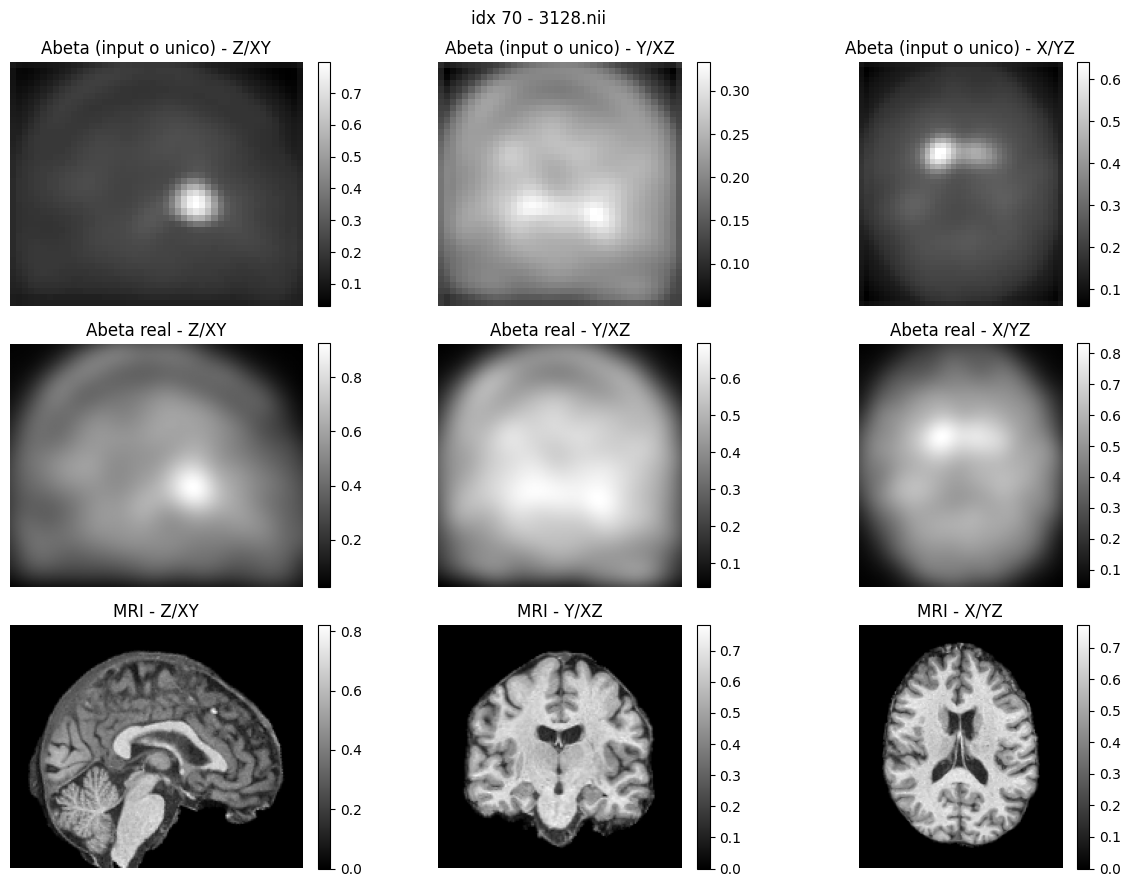

In [13]:
def plot_center_slices(idx=0):
    sample = dataset[idx]
    if dataset_name == "OneDataset":
        abeta, name = sample
        mri = None
    else:
        mri, abeta, abeta_real, name, label = sample

    def mid_slices(vol):
        z = vol.shape[0] // 2
        y = vol.shape[1] // 2
        x = vol.shape[2] // 2
        return vol[z], vol[:, y, :], vol[:, :, x]

    figs = []
    titles = []

    # Abeta generado (o unico en OneDataset)
    a_xy, a_xz, a_yz = mid_slices(abeta)
    figs.append((a_xy, a_xz, a_yz))
    titles.append("Abeta (input o unico)")

    # Abeta real de referencia (solo TwoDataset)
    if dataset_name == "TwoDataset":
        ar_xy, ar_xz, ar_yz = mid_slices(abeta_real)
        figs.append((ar_xy, ar_xz, ar_yz))
        titles.append("Abeta real")

    # MRI (solo TwoDataset)
    if mri is not None:
        m_xy, m_xz, m_yz = mid_slices(mri)
        figs.append((m_xy, m_xz, m_yz))
        titles.append("MRI")

    cols = 3
    rows = len(figs)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, (slices, title) in enumerate(zip(figs, titles)):
        for c, slc in enumerate(slices):
            ax = axes[r, c]
            im = ax.imshow(slc.T, cmap="gray", origin="lower")
            ax.axis("off")
            ax.set_title(f"{title} - {['Z/XY','Y/XZ','X/YZ'][c]}")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    fig.suptitle(f"idx {idx} - {name}")
    plt.tight_layout()
    plt.show()

plot_center_slices(70)


## Explorar varios indices

Itera sobre algunos indices para verificar que todos los datos se lean correctamente.


In [ ]:
for i in range(min(10, len(dataset))):
    print("---")
    inspect_index(i)